In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [2]:
nop.plot_setup()

In [3]:
def get_name(N_nodes, nn, sd_llf):
    return str(
        "../testing/@MA1-FirstBuilder/output2/"
        + "out"
        + "-N"
        + str(N_nodes)
        + "-nn"
        + str(nn)
        + "-sd_llf"
        + str(sd_llf)
        + ".h5"
    )


def get_mu(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["mu_nodes"]


def get_kld(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs
def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / 2 * sd2**2 - 1 / 2


def get_ls(sd_llf):
    if sd_llf == 1:
        ls = "--"
    elif sd_llf < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [4]:
# Parameter ranges used for simulations
N_arr = [1]
nn_arr = [0]
sd_llf_arr = np.round(np.arange(0.5, 5.1, 0.5), 1)
t_arr = np.arange(0, len(get_kld(N_arr[0], nn_arr[0], sd_llf_arr[-1])), 1)
# t_arr.shape

In [5]:
# Initialize xarray Dataset
tmp_arr = np.empty((len(N_arr), len(nn_arr), len(sd_llf_arr), len(t_arr), 150))
ds = xr.Dataset(
    {
        "mu": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
        "kld": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "time": t_arr,
        "node": np.arange(150),
    },
)
del tmp_arr

# Populate the Dataset
for N in N_arr:
    for sd_llf in sd_llf_arr:
        if N == 1:
            nn = 0
            ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_mu(
                N, nn, sd_llf
            )
            ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_kld(
                N, nn, sd_llf
            )
        elif N == 2:
            nn = 1
            ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_mu(
                N, nn, sd_llf
            )
            ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_kld(
                N, nn, sd_llf
            )
        else:
            for nn in nn_arr[2:]:
                ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = (
                    get_mu(N, nn, sd_llf)
                )
                ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = (
                    get_kld(N, nn, sd_llf)
                )

ds

<xarray.Dataset> Size: 240MB
Dimensions:  (N: 1, nn: 1, sd_llf: 10, time: 10001, node: 150)
Coordinates:
  * N        (N) int64 8B 1
  * nn       (nn) int64 8B 0
  * sd_llf   (sd_llf) float64 80B 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * time     (time) int64 80kB 0 1 2 3 4 5 6 ... 9995 9996 9997 9998 9999 10000
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, node) float64 120MB 0.0 0.0 ... 0.01581
    kld      (N, nn, sd_llf, time, node) float64 120MB 1.856 1.856 ... 1.139

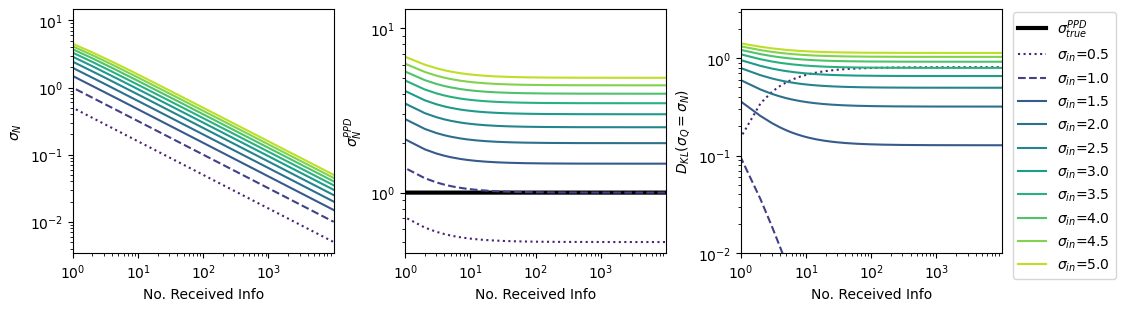

In [33]:
# How would we expect the KLD to develop, given different sd_in, sd0?


sd_arr = np.array([0.5, 0.75, 1.0, 1.25, 1.5])
sd_arr = ds.sd_llf.values
sd0 = 10
N = int(10**4)
x = np.arange(N)

# Plotting...
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# Preparation: Add line or real sd_PPD=1, set colorcycles
ax[1].plot(x, np.ones(N), color="black", lw=3, label="$\sigma^{PPD}_{true}$")
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i in np.arange(3):
    ax[i].set_prop_cycle(color=colors)

for sd_in in sd_arr:
    sd = sd_N(sd0, sd_in, x)
    # sd_N(N)
    ax[0].plot(
        sd,
        ls=get_ls(sd_in),
    )

    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1].plot(
        sd_PPD,
        ls=get_ls(sd_in),
    )

    # KLD_PPD(N), given same means and sd_P=1
    ax[2].plot(
        np.log(sd_PPD) + 1 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_{in}$=" + str(sd_in),
    )

for i in np.arange(3):
    ax[i].loglog()
    ax[i].set_xlim((x[1], x[-1]))
    ax[i].set_xlabel("No. Received Info")

ax[0].set_ylabel("$\sigma_N$")
ax[1].set_ylabel("$\sigma^{PPD}_N$")
ax[2].set_ylabel("$D_{KL}(\sigma_Q=\sigma_N)$")
ax[2].set_ylim(10**-2, 10**0.5)
fig.legend(bbox_to_anchor=(1, 1), loc="upper left")

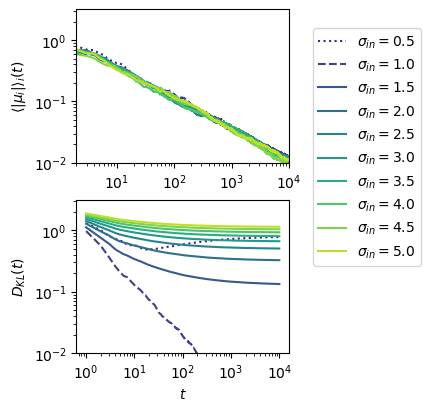

In [30]:
# <KLD>(t) for N=1 -- 1 plot each over sd_llf_arr


samples = 150
N_range = np.arange(0, 150, int(150 / samples))
N_tmp = [1]
sd_llf_arr = ds.sd_llf.values
time = ds.time.values[1:]
x = len(N_tmp)
y = 2
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y), sharey=True)
color = nop.get_colorcycle(N_colors=len(sd_llf_arr))

# mu(t) figure
i = 0
for j, N in enumerate(N_tmp):
    if N == 1:
        nn = 0
    elif N == 2:
        nn = 1
    else:
        break
    for k, sd_llf in enumerate(ds.sd_llf.values):
        if j == 0:
            label = "$\sigma_{in}=$" + str(sd_llf)
        else:
            label = "_$\sigma_{in}=$" + str(sd_llf)

        ax[i].plot(
            time,
            np.abs(ds.mu.sel(N=N, nn=nn, sd_llf=sd_llf, time=time, node=N_range)).mean(
                dim="node"
            ),
            color=color[k],
            ls=get_ls(sd_llf),
            label=label,
        )
    ax[i].set_xlim(time[1], time[-1])
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
ax[i].set_ylabel("$\langle |\mu_i|\\rangle_i(t)$")

# <KLD(t)>_runs figure
N_range = np.arange(0, 150)
i = 1
for j, N in enumerate(N_tmp):
    if N == 1:
        nn = 0
    elif N == 2:
        nn = 1
    else:
        break
    for k, sd_llf in enumerate(sd_llf_arr):
        ax[i].plot(
            time,
            ds.kld.sel(N=N, nn=nn, sd_llf=sd_llf, time=time, node=N_range).mean(
                dim="node"
            ),
            color=color[k],
            ls=get_ls(sd_llf),
        )
    ax[i].set_xlabel("$t$")
    ax[i].set_ylim((10**-2, 10**0.5))
    ax[i].loglog()
ax[1].set_ylabel("$D_{KL}(t)$")


fig.legend(bbox_to_anchor=(1.0, 0.96), loc="upper left")